<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Деление-на-выборки-и-создание-фич" data-toc-modified-id="Деление-на-выборки-и-создание-фич-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Деление на выборки и создание фич</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor, Pool

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data = data.resample("1H").sum()

In [6]:
data['rolling_mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

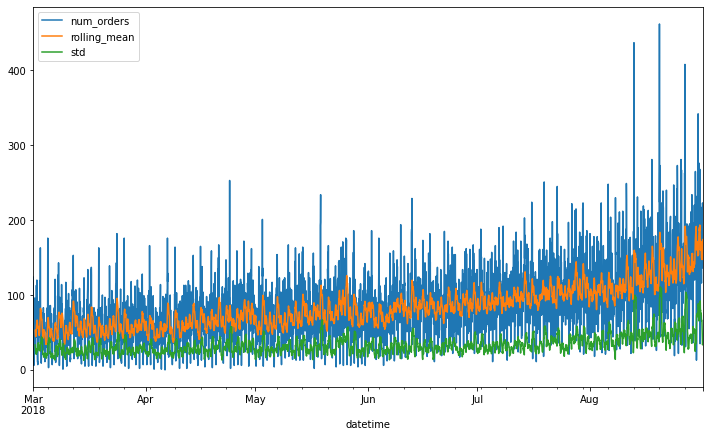

In [7]:
data.plot(figsize=(12,7));

**Расширенный тест Дики-Фуллера**

H0: Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

H1: временной ряд является стационарным.

In [8]:
num_orders = data['num_orders']
st_test = adfuller(num_orders)

if st_test[1] < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен.')
else:
    print('Нулевая гипотеза не отвергается. Ряд не стационарен.')

Нулевая гипотеза отвергается. Ряд стационарен.


**Вывод:** В данном пункте были загружены и изучены, а также ресемплирование по одному часу. По критерию Дики-Фуллера временной ряд считается стационарным, однако необходимо изучить тренды и сезонность.

## Анализ

Посмотрим тренды и сезонность заказа такси.

In [9]:
decomposed = seasonal_decompose(data['num_orders']) 


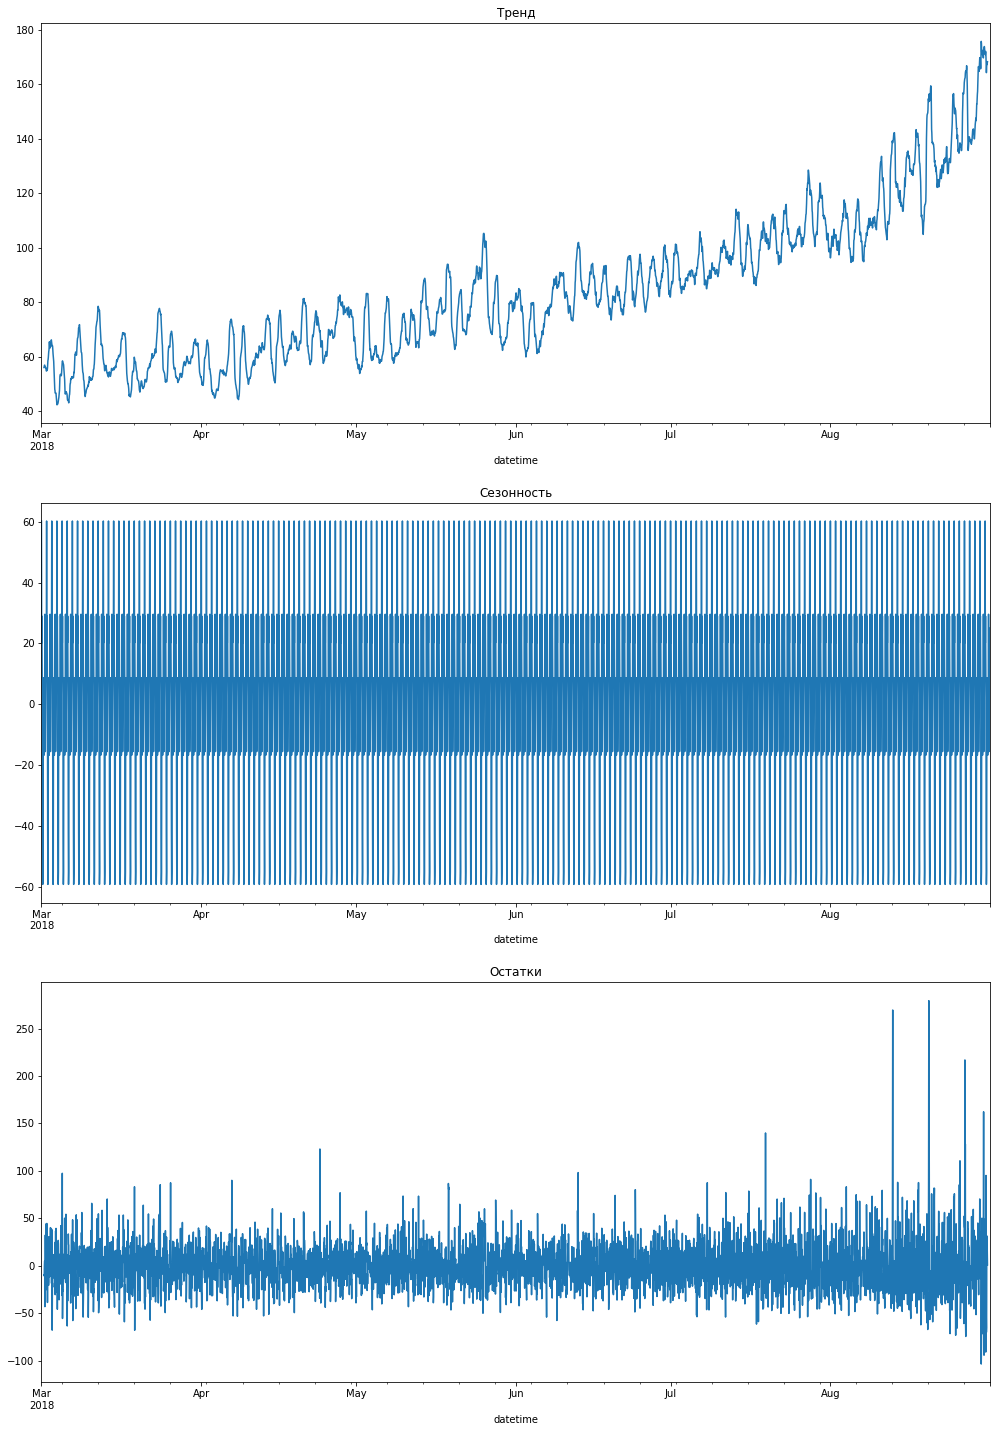

In [10]:
fig,ax = plt.subplots(3,1,figsize = (17,25))

decomposed.trend.plot(ax=ax[0],title = 'Тренд');
decomposed.seasonal.plot(ax=ax[1],title = 'Сезонность');
decomposed.resid.plot(ax=ax[2],title = 'Остатки');

Изучим данные по последним 2 неделям.

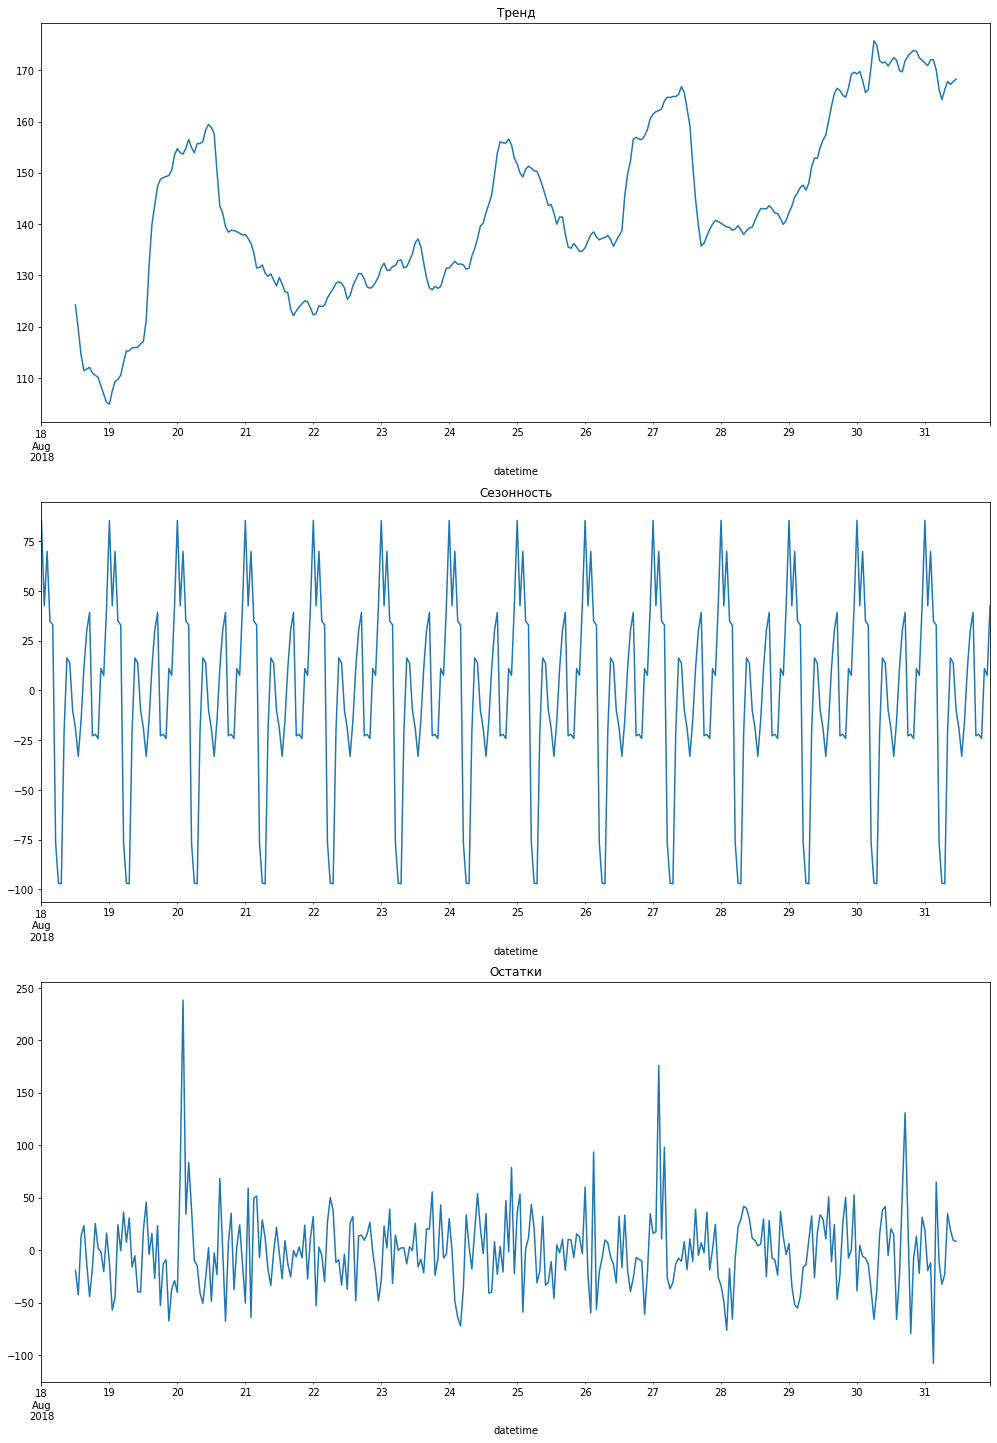

In [11]:
decomposed = seasonal_decompose(data['num_orders']['2018-08-18':'2018-08-31'])
fig,ax = plt.subplots(3,1,figsize = (17,25))

decomposed.trend.plot(ax=ax[0],title = 'Тренд');
decomposed.seasonal.plot(ax=ax[1],title = 'Сезонность');
decomposed.resid.plot(ax=ax[2],title = 'Остатки');

Изучим данные по последним 2 месяцам.

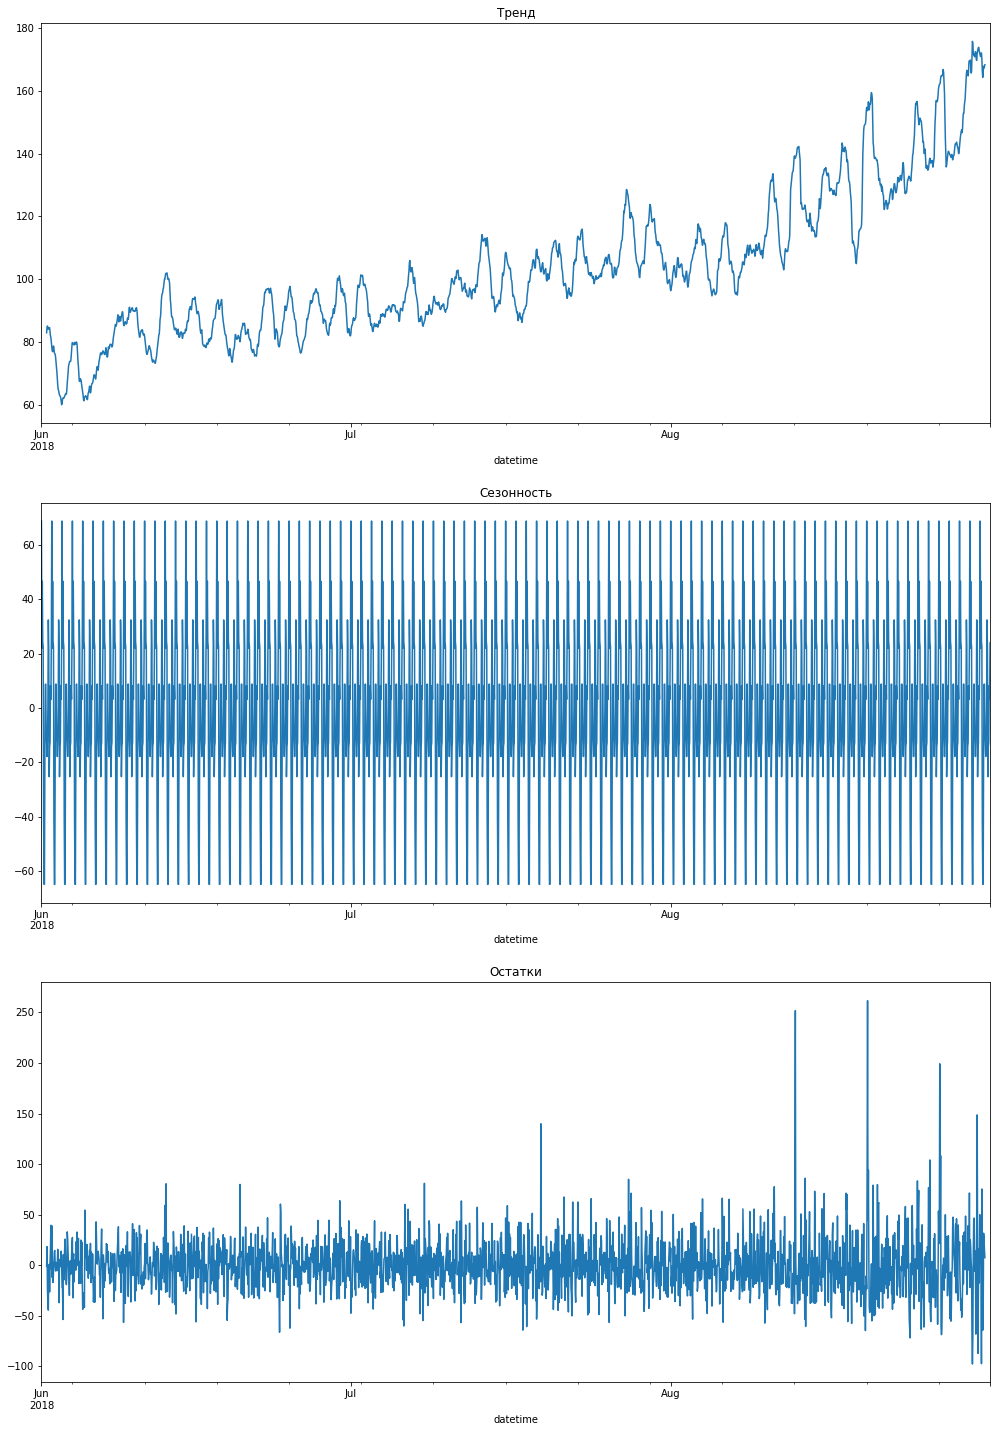

In [12]:
decomposed = seasonal_decompose(data['num_orders']['2018-06':'2018-08'])
fig,ax = plt.subplots(3,1,figsize = (17,25))

decomposed.trend.plot(ax=ax[0],title = 'Тренд');
decomposed.seasonal.plot(ax=ax[1],title = 'Сезонность');
decomposed.resid.plot(ax=ax[2],title = 'Остатки');

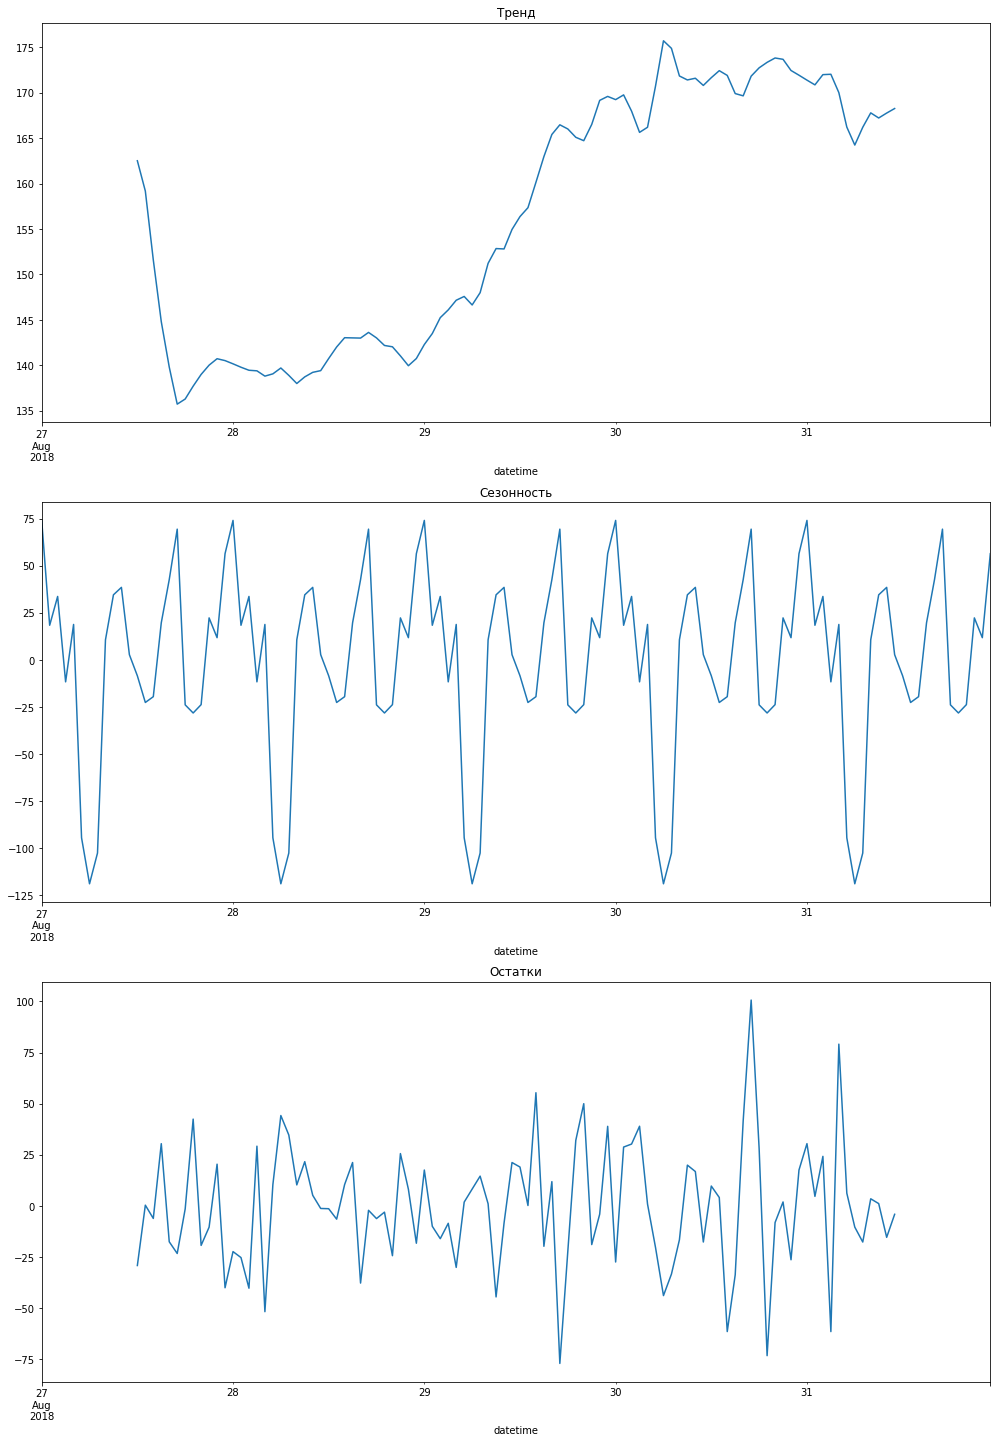

In [13]:
decomposed = seasonal_decompose(data['num_orders']['2018-08-27':'2018-08-31'])
fig,ax = plt.subplots(3,1,figsize = (17,25))

decomposed.trend.plot(ax=ax[0],title = 'Тренд');
decomposed.seasonal.plot(ax=ax[1],title = 'Сезонность');
decomposed.resid.plot(ax=ax[2],title = 'Остатки');

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

**Вывод:**
1. Есть тренд на увеличение среднего, то есть количество пользователей растет
2. Присутсвует ежедневная сезонность, необходимо добавить признак day
3. В течении недели присутствует сезонность(есть пик в понедльник, затем спад и снова рост с середины недели), необходимо добавить признак dayofweek
4. Необходимо добавить признак month, т. к. данные меняются от месяца к месяцу.
5. Так как количество заказов зависит от вермени суток, добавим фичу hour.

## Обучение

### Деление на выборки и создание фич

In [15]:
def split_data(data):
    train, rem = train_test_split(data, shuffle = False, train_size=0.8)
    valid, test = train_test_split(rem, shuffle = False, test_size=0.5)
    
    train = train.dropna()
    (train_features,
     valid_features,
     test_features) = (train.drop('num_orders',axis = 1),
                       valid.drop('num_orders',axis = 1),
                       test.drop('num_orders',axis = 1))
    (train_target,
     valid_target,
     test_target) = (train['num_orders'],
                     valid['num_orders'],
                     test['num_orders'])
    return (train_features, valid_features, test_features,
            train_target,valid_target,test_target)

In [16]:
data.drop(['rolling_mean','std'], axis=1, inplace =True)

In [17]:
make_features(data, 1, 24)
(features_train, features_valid, features_test,
 target_train, target_valid, target_test) = split_data(data)

In [18]:
features_train.shape[0], features_valid.shape[0], features_test.shape[0]

(3508, 442, 442)

### LinearRegression

In [19]:
model = LinearRegression()

model.fit(features_train, target_train)
train_pred = model.predict(features_valid)

mean_squared_error(target_valid, train_pred, squared=False)

41.10280802905622

### RandomForest

In [20]:
splits = TimeSeriesSplit(n_splits=3)
RF = RandomForestRegressor()
parametrs = {"max_depth": [1,10,2],"n_estimators":[20,150,10]}
RF_grid = GridSearchCV(RF,parametrs,cv = splits, n_jobs=-1, scoring='neg_root_mean_squared_error')
RF_grid.fit(features_train,target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 10, 2],
                         'n_estimators': [20, 150, 10]},
             scoring='neg_root_mean_squared_error')

In [21]:
RF_grid.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=150)

In [22]:
RF = RF_grid.best_estimator_.fit(features_train, target_train)
train_pred = RF.predict(features_valid)
mean_squared_error(target_valid, train_pred, squared=False)

32.7112245697009

### CatBoostRegressor

In [23]:
catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth': [4, 6, 10],
                  'l2_leaf_reg': [1, 3, 5]}
catboost_grid = catboost.grid_search(parameters_cat,
                                     Pool(features_train,target_train),
                                     cv=splits,
                                     verbose=True)

0:	learn: 74.5688859	test: 100.8962527	best: 100.8962527 (0)	total: 47.2ms	remaining: 47.1s
1:	learn: 72.6873198	test: 98.7088868	best: 98.7088868 (1)	total: 48.2ms	remaining: 24s
2:	learn: 70.8897473	test: 96.5046619	best: 96.5046619 (2)	total: 48.7ms	remaining: 16.2s
3:	learn: 69.1054485	test: 94.4536581	best: 94.4536581 (3)	total: 49.3ms	remaining: 12.3s
4:	learn: 67.4160771	test: 92.3753819	best: 92.3753819 (4)	total: 49.9ms	remaining: 9.93s
5:	learn: 65.7433725	test: 90.5517376	best: 90.5517376 (5)	total: 50.5ms	remaining: 8.36s
6:	learn: 64.1544908	test: 88.5213648	best: 88.5213648 (6)	total: 51ms	remaining: 7.23s
7:	learn: 62.6342313	test: 86.7132368	best: 86.7132368 (7)	total: 51.5ms	remaining: 6.39s
8:	learn: 61.1047348	test: 84.8580158	best: 84.8580158 (8)	total: 52.1ms	remaining: 5.73s
9:	learn: 59.6186077	test: 83.1594191	best: 83.1594191 (9)	total: 52.7ms	remaining: 5.21s
10:	learn: 58.2482779	test: 81.5584390	best: 81.5584390 (10)	total: 53.2ms	remaining: 4.78s
11:	learn:

In [24]:
catboost_grid['params']

{'depth': 4, 'l2_leaf_reg': 1}

In [25]:
final_cat = CatBoostRegressor(depth=4, 
                              l2_leaf_reg=1,
                              loss_function='RMSE',
                              verbose=100)
final_cat.fit(Pool(features_train,target_train))
train_pred = final_cat.predict(features_valid)
mean_squared_error(target_valid, train_pred, squared=False)

0:	learn: 35.3287400	total: 827us	remaining: 827ms
100:	learn: 23.7040548	total: 61.8ms	remaining: 550ms
200:	learn: 22.2153860	total: 122ms	remaining: 484ms
300:	learn: 21.2469040	total: 180ms	remaining: 419ms
400:	learn: 20.5687041	total: 240ms	remaining: 358ms
500:	learn: 20.0266527	total: 299ms	remaining: 298ms
600:	learn: 19.6028769	total: 359ms	remaining: 238ms
700:	learn: 19.2443794	total: 426ms	remaining: 182ms
800:	learn: 18.9555544	total: 486ms	remaining: 121ms
900:	learn: 18.6872783	total: 550ms	remaining: 60.4ms
999:	learn: 18.4423925	total: 617ms	remaining: 0us


30.694969516344184

**Вывод:** Данные были поделены на 3 выборки(train, valid и test). Были протестированы следующие модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor


По данному пункту на основе train и valid выборок, я сделал вывод, что CatBoostRegressor дает лучшие результаты, поэтому я выбираю эту модель для тестирования.

## Тестирование

In [26]:
pretest_features = pd.concat([features_train, features_valid])
pretest_target = pd.concat([target_train, target_valid])

In [27]:
final_cat.fit(pretest_features, pretest_target)
train_pred = final_cat.predict(features_test)

mean_squared_error(target_test, train_pred, squared=False)

0:	learn: 38.1796218	total: 852us	remaining: 852ms
100:	learn: 25.1197285	total: 62.2ms	remaining: 554ms
200:	learn: 23.3487095	total: 124ms	remaining: 492ms
300:	learn: 22.2492003	total: 186ms	remaining: 432ms
400:	learn: 21.4164520	total: 249ms	remaining: 372ms
500:	learn: 20.8562206	total: 313ms	remaining: 312ms
600:	learn: 20.4070908	total: 377ms	remaining: 250ms
700:	learn: 20.0467911	total: 445ms	remaining: 190ms
800:	learn: 19.7136227	total: 507ms	remaining: 126ms
900:	learn: 19.4231740	total: 569ms	remaining: 62.6ms
999:	learn: 19.1524580	total: 633ms	remaining: 0us


44.48089928223313

**Вывод:** Перед тем как обучить финальную модель, я соединяю train и valid выборки для точности. Итоговая модель дала **RMSE = 44.48** на тестовой выборке.

In [28]:
pred_value = pd.Series(data=train_pred, index=target_test.index)

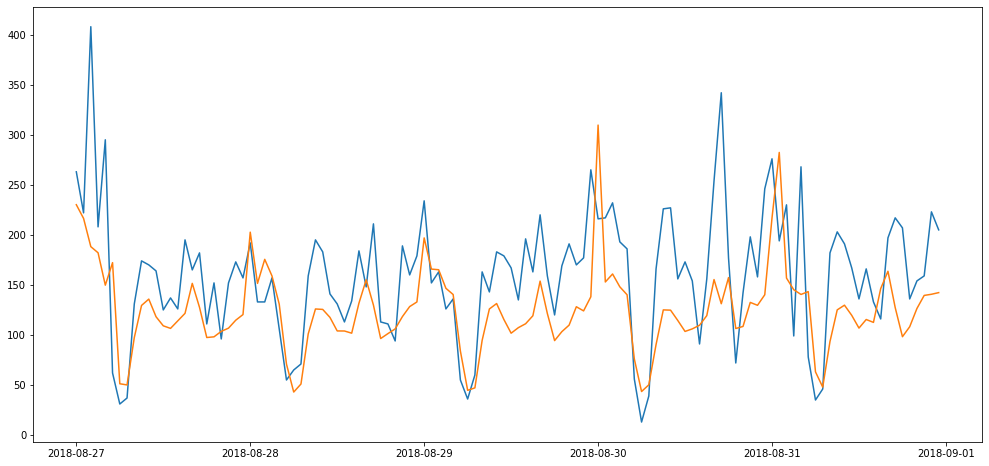

In [29]:
plt.figure(figsize=(17,8))
plt.plot(target_test['2018-08-27':'2018-08-31'].index, 
         target_test['2018-08-27':'2018-08-31'],
         pred_value['2018-08-27':'2018-08-31'].index, 
         pred_value['2018-08-27':'2018-08-31'])

## Итоговый вывод
В ходе данного проекта были:
1. Загружены данные и выполнено их ресемплирование часу.
2. Проанализирована сезонность и тренд в данных. На основе анализа были добавлены фичи для обучения модели.
3. На train были обучены, а на valid проверены 3 модели: регрессия, случайный лес и CatBoostRegressor. Лучше всех справился CatBoostRegressor с **RMSE = 30.69**.
4. На тесте проверена финальная модель **CatBoostRegressor** с наилучшими гиперпараметрами. Итоговый результат составил **RMSE = 43.61**, что является приемлемым результатом для данного проекта.